# Import Libraries

In [42]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load Airlines Time series dataset

In [43]:
def read_from_drive(url):
  file_id = url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
  url = requests.get(dwn_url).text
  csv_raw = StringIO(url)
  return pd.read_csv(csv_raw,  usecols=[1], engine='python')

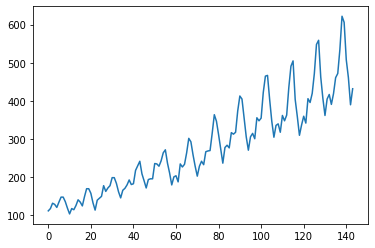

In [44]:

dataset = read_from_drive("https://drive.google.com/file/d/1fJP51fvbwnoNckVS0FOaHeAKR6n_Dfdd/view?usp=sharing")
plt.plot(dataset)
plt.show()

# RNN + LSTM with Window

Epoch 1/100
92/92 - 1s - loss: 0.0593
Epoch 2/100
92/92 - 0s - loss: 0.0231
Epoch 3/100
92/92 - 0s - loss: 0.0177
Epoch 4/100
92/92 - 0s - loss: 0.0153
Epoch 5/100
92/92 - 0s - loss: 0.0135
Epoch 6/100
92/92 - 0s - loss: 0.0116
Epoch 7/100
92/92 - 0s - loss: 0.0101
Epoch 8/100
92/92 - 0s - loss: 0.0087
Epoch 9/100
92/92 - 0s - loss: 0.0073
Epoch 10/100
92/92 - 0s - loss: 0.0065
Epoch 11/100
92/92 - 0s - loss: 0.0056
Epoch 12/100
92/92 - 0s - loss: 0.0051
Epoch 13/100
92/92 - 0s - loss: 0.0047
Epoch 14/100
92/92 - 0s - loss: 0.0045
Epoch 15/100
92/92 - 0s - loss: 0.0045
Epoch 16/100
92/92 - 0s - loss: 0.0042
Epoch 17/100
92/92 - 0s - loss: 0.0043
Epoch 18/100
92/92 - 0s - loss: 0.0044
Epoch 19/100
92/92 - 0s - loss: 0.0043
Epoch 20/100
92/92 - 0s - loss: 0.0043
Epoch 21/100
92/92 - 0s - loss: 0.0041
Epoch 22/100
92/92 - 0s - loss: 0.0041
Epoch 23/100
92/92 - 0s - loss: 0.0041
Epoch 24/100
92/92 - 0s - loss: 0.0041
Epoch 25/100
92/92 - 0s - loss: 0.0041
Epoch 26/100
92/92 - 0s - loss: 0.

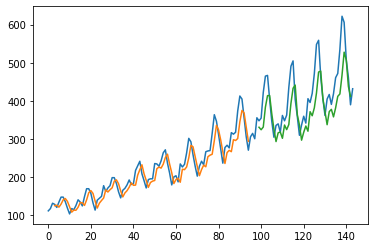

In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = dataset
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Result and Visualisation

Train Score: 25.20 RMSE
Test Score: 61.16 RMSE


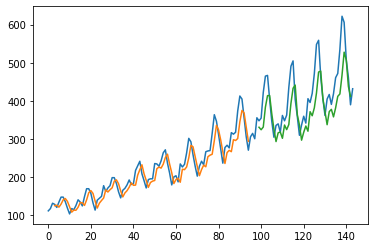

In [41]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()